# Wildland Fire on Indianapolis, IN

The goal of the analysis is to explore the impact of wildfires on Indianapolis, Indiana. Specifically, we will be estimating annual wildfire smoke, as a way to measure wildfire impact in the last 60 years.

In [1]:
#########
#
#    IMPORTS
#

# In-built libraries
import os
import json

# Third-party libraries
import numpy as np
import pandas as pd
import geopandas as gpd

# Other third-party libraries
import copy
import fiona
from shapely.geometry import Polygon, Point
import contextily as cx
import folium.folium
import matplotlib.pyplot as plt
from geopandas.explore import _categorical_legend
from folium.plugins import Geocoder
from matplotlib.colors import rgb2hex

In [2]:
#########
#
#    CONSTANTS
#
DATA_PATH = "data/Fire_Feature/Fire_Feature_Data.gdb"

In [3]:
#########
#
#    FUNCTIONS
#
def plot_gdf(gdf: gpd.GeoDataFrame, column: str, cmap: str = 'viridis', title: str = 'Map', 
    figsize: tuple = (10, 10), **kwargs):
    """
    Plot a GeoDataFrame with a specified column and colormap

    Parameters
    ----------
    gdf : gpd.GeoDataFrame
        The GeoDataFrame to plot
    
    column : str
        The column to plot
    
    cmap : str
        The colormap to use
    
    title : str
        The title of the plot
    
    figsize : tuple
        The size of the plot
    
    **kwargs
        Additional keyword arguments to pass to the plot function
        **kwargs
            Additional keyword arguments to pass to the plot function.
            Possible kwargs for this function include:
            - legend_kwds: Additional keyword arguments for customizing the legend
            - classification_kwds: Additional keyword arguments for customizing the classification
    """
    gdf_crs = gdf.to_crs(epsg=3857)
    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize = figsize)

    # Plot data
    ax = gdf_crs.plot(figsize=figsize, alpha=0.9, column = column,
        ax = ax,
        cmap = cmap,
        legend = True,
        legend_kwds = kwargs['legend_kwds'] if 'legend_kwds' in kwargs else {},
        scheme=None if 'classification_kwds' not in kwargs else "User_Defined",
        classification_kwds = kwargs['classification_kwds'] if 'classification_kwds' in kwargs else {})

    cx.add_basemap(ax)

    # Set title
    ax.set_title(title, fontdict = {'fontsize': '20', 'fontweight' : '4'})

    return fig, ax

def explore_gdf(gdf: gpd.GeoDataFrame, column: str, cmap: str = 'viridis', title: str = 'Map', figsize: tuple = (10, 10),
                search_bar: bool = True,
                bins: list = None, bin_labels: list = None, bin_column: str = '_bin') -> folium.Map:
    """
    Explore a GeoDataFrame with a specified column and colormap.
    If bins, bin_labels, and bin_column are provided, the data will be classified into bins, and the bins will be plotted.
    
    Warning:
    The binned column will also be added to the GeoDataFrame. Feel free to drop this column if you don't need it. 

    Parameters
    ----------
    gdf : gpd.GeoDataFrame
        The GeoDataFrame to plot
    
    column : str
        The column to plot
    
    cmap : str
        The colormap to use
    
    title : str
        The title of the plot
    
    figsize : tuple
        The size of the plot

    bins : list
        The bins to use for classification
    
    bin_labels : list
        The labels for the bins
    
    bin_column : str
        The column to store the bin values
    """
    if bins is None or len(bins) == 0:
        m = gdf.explore(column = column, cmap = cmap, figsize = figsize, title = title)
        return m

    if bin_labels is None or len(bin_labels) == 0:
        bin_labels = bins

    bins_true_min, bins_true_max = 0, len(bins)
    bins_true_length = bins_true_max - bins_true_min + 1

    gdf[bin_column] = np.digitize(gdf[column], bins=bins, right=False)
    cmap_listed = plt.colormaps[cmap].resampled(bins_true_length)
    # legend_elements = [Patch(facecolor=cmap_listed(i), edgecolor='black', 
    #                          label=bin_labels[i]) for i in range(len(bin_labels))]
    colors = [rgb2hex(cmap_listed(i)) for i in range(bins_true_length)]

    m = gdf.explore(bin_column, cmap=cmap, legend = False, vmin=bins_true_min, vmax=bins_true_max, figsize=figsize, title=title)
    _categorical_legend(
        m=m,
        title=title,
        categories=bin_labels,
        colors=colors
    )

    if search_bar:
        Geocoder().add_to(m)

    return m

## Load the USGS Wildland Fire Combined Dataset

The US wildfires data was collected and processed by the US Geological Survey in the following page: [Combined wildland fire datasets for the United States and certain territories, 1800s-Present (combined wildland fire polygons)](https://www.sciencebase.gov/catalog/item/61aa537dd34eb622f699df81)

For this analysis, we will be using the Geodatabase file stored as `Fire_Feature_Data_Pro2_8_Geodatabase.zip`. This folder includes the following: 
- A raw merged dataset containing duplicates 
- A post-processed, duplicate-free, dataset that comprises both wildfires and prescribed fires from mid 1800s to the 2021 compiled from 40 different original wildfire datasets.

The data was extracted using `geopandas`, `fiona` and `shapely`. \
Note: While the initial attempt was to utilize the `GeoJSON files.zip` file, since GeoJSON is more easy to work with, when using `geopandas`, it turns out that this file is not appropriate for direct usage, because it still, to a large extent, follows the ESRI format, which is more suitable for ArcGIS. Thus, `geopandas` fails to process some of the rows properly and errors out while trying to load the entire geojson file.\
The Geodatabase file proved less challenging to work with, since, as it turns out, `geopandas` can indeed work with Geodatabase files of ESRI format.

In [4]:
# Use fiona package to list layers present in the geodatabase
# The combined layer will be loaded into a GeoDataFrame using geopandas
layers: list = fiona.listlayers(DATA_PATH)
print("Available layers:", layers)

Available layers: ['USGS_Wildland_Fire_Combined_Dataset', 'USGS_Wildland_Fires_Overlapping_Fire_Data', 'USGS_Wildland_Fire_Merged_Dataset']


In [5]:
COMBINED_DATASET_LAYER = "USGS_Wildland_Fire_Combined_Dataset"

In [6]:
fire_feature_gdf: gpd.GeoDataFrame = gpd.read_file(DATA_PATH, layer=COMBINED_DATASET_LAYER)

/home/hnaidu36/miniforge3/envs/data512/lib/python3.12/site-packages/pyogrio/raw.py:198: RuntimeWarning: organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
  return ogr_read(


In [7]:
fire_feature_gdf.head(1)

,USGS_Assigned_ID,Assigned_Fire_Type,Fire_Year,Fire_Polygon_Tier,Fire_Attribute_Tiers,GIS_Acres,GIS_Hectares,Source_Datasets,Listed_Fire_Types,Listed_Fire_Names,...,Wildfire_Notice,Prescribed_Burn_Notice,Wildfire_and_Rx_Flag,Overlap_Within_1_or_2_Flag,Circleness_Scale,Circle_Flag,Exclude_From_Summary_Rasters,Shape_Length,Shape_Area,geometry
0,1,Wildfire,1860,1,1 (1),3940.207089,1594.545237,Comb_National_NIFC_Interagency_Fire_Perimeter_...,Wildfire (1),Big Quilcene River (1),...,Wildfire mapping prior to 1984 was inconsisten...,Prescribed fire data in this dataset represent...,None,None,0.04759,NaN,No,64888.449849,1.594545e+07,"MULTIPOLYGON (((-1883775.596 1194154.192, -188..."


In [8]:
print(f"The dataframe contains {fire_feature_gdf.shape[0]} observations and {fire_feature_gdf.shape[1]} attributes.")
print(f"The CRS of the GeoDataFrame is: {fire_feature_gdf.crs}")

The dataframe contains 135061 observations and 30 attributes.
The CRS of the GeoDataFrame is: PROJCS["North_America_Albers_Equal_Area_Conic",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Albers_Conic_Equal_Area"],PARAMETER["latitude_of_center",40],PARAMETER["longitude_of_center",-96],PARAMETER["standard_parallel_1",20],PARAMETER["standard_parallel_2",60],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["ESRI","102008"]]


In [9]:
fire_feature_gdf.columns

Index(['USGS_Assigned_ID', 'Assigned_Fire_Type', 'Fire_Year',
       'Fire_Polygon_Tier', 'Fire_Attribute_Tiers', 'GIS_Acres',
       'GIS_Hectares', 'Source_Datasets', 'Listed_Fire_Types',
       'Listed_Fire_Names', 'Listed_Fire_Codes', 'Listed_Fire_IDs',
       'Listed_Fire_IRWIN_IDs', 'Listed_Fire_Dates', 'Listed_Fire_Causes',
       'Listed_Fire_Cause_Class', 'Listed_Rx_Reported_Acres',
       'Listed_Map_Digitize_Methods', 'Listed_Notes', 'Processing_Notes',
       'Wildfire_Notice', 'Prescribed_Burn_Notice', 'Wildfire_and_Rx_Flag',
       'Overlap_Within_1_or_2_Flag', 'Circleness_Scale', 'Circle_Flag',
       'Exclude_From_Summary_Rasters', 'Shape_Length', 'Shape_Area',
       'geometry'],
      dtype='object')

## Filter Data to observations relevant to Indianapolis, IN

In this analysis, we will only focus in a select subset of Wildland fires that satisfy the following conditions:
- Occurred in the last 60 years: [1964 - Present]
- Within 650 miles of Indianapolis, IN 

In [10]:
#########
#
#    Additional Constants
#
DISTANCE_EPSG = 5070
WORLD_EPSG = 4326

METERS_TO_MILES = 0.00062137

DISTANCE_THRESHOLD_MILES = 650

INDIANAPOLIS_COORDINATES = (39.7684, -86.1580)
INDIANAPOLIS_POINT: Point = Point(INDIANAPOLIS_COORDINATES[1], INDIANAPOLIS_COORDINATES[0])  # (longitude, latitude)

### Date Filtering

In [11]:
# Get Wildland fires that occurred only in the last 60 years: [1964 - Present]
fire_feature_valid_dates_gdf: gpd.GeoDataFrame = fire_feature_gdf[fire_feature_gdf['Fire_Year'] >= 1964]

# Note: final_fire_feature_gdf will be the final dataset used for analysis, after all the filtering and processing

### CRS Conversion Set up

After further analysis on GIS, it turns out that `EPSG:4326` may not be ideal for distance calculation as it does not take into account the curvature of the Earth. 

Instead, we will go with `EPSG:5070` (Conus Albers / USA Contiguous Albers Equal Area Conic). This CRS is indeed well-suited for the contiguous United States and designed specifically to minimize distortion for both area and distance across this region. It should provide accurate distance calculations across the entire country, making it ideal for our needs.

However, `EPSG:4326` will nonetheless be useful for visualization purposes, since it works seamlessly with `geopandas.explore()`

Also, the conversion from `ESRI:102008` to `EPSG:4326` is the only valid ESRI-EPSG transformation in this context, hence `EPSG:4326` will be the first transformation made

To continue processing of the dataframes, it would be prudent to convert the geometry from the ESRI:102008 coordinate system to EPSG:4326 coordinates.

Note: The following code was executed on a system equipped with a 12th Gen Intel® Core™ i7-12700H processor (2.30 GHz). The total execution time for this loop was around 1 minute.

In [12]:
# Convert the geometry from ESRI:102008 to ESRI:102005
fire_feature_valid_dates_gdf: gpd.GeoDataFrame = fire_feature_valid_dates_gdf.to_crs(epsg=WORLD_EPSG)

# Convert the geometry of Indianapolis point to GeoSeries with ESRI:102005
Indianapolis_projected_point = gpd.GeoSeries([INDIANAPOLIS_POINT], crs=f"EPSG:{WORLD_EPSG}")

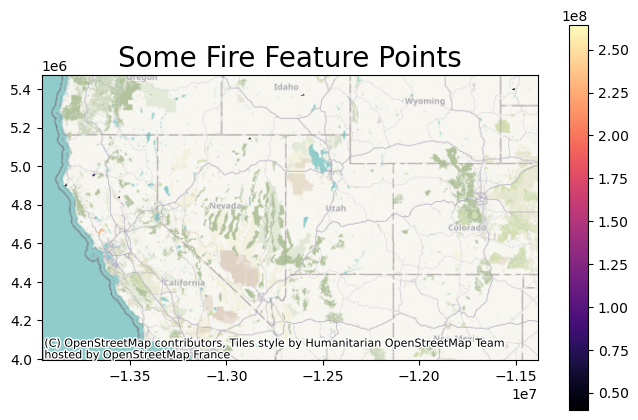

In [13]:
# As mentioned, EPSG:4326 can be used for mapping, but for distance calculations, we will use EPSG:5070
fix, ax = plot_gdf(fire_feature_valid_dates_gdf[:10], 'Shape_Area', cmap='magma', title='Some Fire Feature Points', 
    figsize=(8, 5))
# plt.savefig(os.path.join(SAVE_PATH, 'transaction_counts.png'))
plt.show()

### Distance Filtering

In [14]:
#########
#
#    Additional Constants
DISTANCE_COL = 'Distance'

In [15]:
fire_feature_valid_dates_gdf[DISTANCE_COL] = \
fire_feature_valid_dates_gdf.to_crs(epsg=DISTANCE_EPSG)\
    .distance(Indianapolis_projected_point.to_crs(epsg=DISTANCE_EPSG)[0]) * METERS_TO_MILES

In [17]:
# Filter rows that have Distance less than the threshold
fire_feature_valid_gdf = fire_feature_valid_dates_gdf[fire_feature_valid_dates_gdf[DISTANCE_COL] <= DISTANCE_THRESHOLD_MILES]